# Exploratory Data Analysis

This notebook provides a starter analysis of financial data, including account states, transactions, and payments. It demonstrates how to load the input data and plots distributions for the population as well as time series for individual agents. This notebook does not do EDA on the labels. That is left up to you.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotting import (
    plot_merchant_type_distribution,
    plot_transaction_amount_distribution,
    plot_event_distribution,
    plot_behavior_over_time,
    display_table_info
)

In [4]:
# Load data
account_state_log = pd.read_csv('./Datasets/account_state_log.csv')
transactions_log = pd.read_csv('./Datasets/transactions_log.csv', parse_dates=['timestamp'])
payments_log = pd.read_csv('./Datasets/payments_log.csv', parse_dates=['timestamp'])

In [8]:
labels = pd.read_csv('./Datasets/labels.csv')

In [9]:
labels.head()

,agent_id,charge_off_within_3_months,charge_off_within_6_months,charge_off_within_9_months,charge_off_within_12_months
0,0,0,0,0,0
1,3,0,0,0,0
2,6,0,0,0,0
3,7,0,0,0,0
4,8,0,0,0,0


In [10]:
aggregated = account_state_log.groupby('agent_id').agg({
    'credit_balance': ['mean', 'max', 'last'],  # Average, peak, and final balance
    'credit_utilization': ['mean', 'max', 'last'],  # Utilization stats
    'interest_rate': ['mean', 'last'],  # Average and final interest rate
    'current_missed_payments': ['sum', 'max', 'last'],  # Total, peak, and latest missed payments
    'timestamp': ['min', 'max']  # First and last timestamps
})

# Flatten MultiIndex columns for easier use
aggregated.columns = ['_'.join(col).strip() for col in aggregated.columns]
aggregated.reset_index(inplace=True)

In [11]:
aggregated.head()

,agent_id,credit_balance_mean,credit_balance_max,credit_balance_last,credit_utilization_mean,credit_utilization_max,credit_utilization_last,interest_rate_mean,interest_rate_last,current_missed_payments_sum,current_missed_payments_max,current_missed_payments_last,timestamp_min,timestamp_max
0,0,3054.533833,4964.111415,2505.991415,0.623747,0.993,0.501,0.209866,0.209866,0,0,0,2023-01-01,2023-04-01
1,3,1826.206224,1990.626004,1990.626004,0.927758,0.995,0.995,0.211185,0.211185,0,0,0,2023-01-01,2023-04-01
2,6,649.106037,1279.993400,321.083400,0.227275,0.439,0.107,0.186929,0.187204,0,0,0,2023-01-01,2023-04-01
3,7,1621.523367,1984.664026,1941.344026,0.850923,0.998,0.971,0.216252,0.216252,0,0,0,2023-01-01,2023-04-01
4,8,5748.472329,9973.203428,7835.223428,0.584846,0.997,0.784,0.219701,0.219975,1,1,0,2023-01-01,2023-04-01


In [12]:
aggregated.shape

(7352, 14)

In [13]:
# Multiclass classification
labels['charge_off'] = [1 if x else 0 for x in labels['charge_off_within_3_months'] == 1]
labels['charge_off'] = [2 if x else y for x, y in zip((labels['charge_off_within_6_months'] == 1) & (labels['charge_off'] == 0), labels['charge_off'])]
labels['charge_off'] = [3 if x else y for x, y in zip((labels['charge_off_within_9_months'] == 1) & (labels['charge_off'] == 0), labels['charge_off'])]
labels['charge_off'] = [4 if x else y for x, y in zip((labels['charge_off_within_12_months'] == 1) & (labels['charge_off'] == 0), labels['charge_off'])]



In [14]:
labels['charge_off'].value_counts()

charge_off
0    7150
4      67
3      66
2      57
1      12
Name: count, dtype: int64

In [15]:
# Merge aggregated and labels
merged_data_ag_labels = aggregated.merge(labels[['agent_id', 'charge_off']], on='agent_id', how='inner')

merged_data_ag_labels.head()

,agent_id,credit_balance_mean,credit_balance_max,credit_balance_last,credit_utilization_mean,credit_utilization_max,credit_utilization_last,interest_rate_mean,interest_rate_last,current_missed_payments_sum,current_missed_payments_max,current_missed_payments_last,timestamp_min,timestamp_max,charge_off
0,0,3054.533833,4964.111415,2505.991415,0.623747,0.993,0.501,0.209866,0.209866,0,0,0,2023-01-01,2023-04-01,0
1,3,1826.206224,1990.626004,1990.626004,0.927758,0.995,0.995,0.211185,0.211185,0,0,0,2023-01-01,2023-04-01,0
2,6,649.106037,1279.993400,321.083400,0.227275,0.439,0.107,0.186929,0.187204,0,0,0,2023-01-01,2023-04-01,0
3,7,1621.523367,1984.664026,1941.344026,0.850923,0.998,0.971,0.216252,0.216252,0,0,0,2023-01-01,2023-04-01,0
4,8,5748.472329,9973.203428,7835.223428,0.584846,0.997,0.784,0.219701,0.219975,1,1,0,2023-01-01,2023-04-01,0


In [17]:
merged_data_ag_labels.value_counts('charge_off')

charge_off
0    7150
4      67
3      66
2      57
1      12
Name: count, dtype: int64

In [ ]:
# Oversample the minority classes charge_off = 1, 2,  3, 4
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

ros = RandomOverSampler(sampling_strategy={1: 1000, 2: 1000, 3: 1000, 4: 1000}, random_state=42)

X = merged_data_ag_labels.drop(['agent_id', 'charge_off'], axis=1)
y = merged_data_ag_labels['charge_off']

X_resampled, y_resampled = ros.fit_resample(X, y)

# Check the new class distribution
pd.Series(y_resampled).value_counts()





charge_off
0    7150
2    1000
3    1000
4    1000
1    1000
Name: count, dtype: int64

In [20]:
X_resampled_wo_timestamp = X_resampled.drop(['timestamp_min', 'timestamp_max'], axis=1)

In [21]:
# Train XGBoost model on the resampled data
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_resampled_wo_timestamp, y_resampled, test_size=0.2, random_state=42)

model = XGBClassifier(objective='multi:softmax', num_class=5, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1423
           1       0.99      1.00      1.00       199
           2       0.99      1.00      0.99       223
           3       1.00      1.00      1.00       202
           4       0.98      1.00      0.99       183

    accuracy                           1.00      2230
   macro avg       0.99      1.00      1.00      2230
weighted avg       1.00      1.00      1.00      2230



In [22]:
# Save the model
model.save_model('xgboost_model_second.json')

In [ ]:
# Check if any two columns take the value one together
conditions = [
    (labels['charge_off_within_3_months'] == 1) & (labels['charge_off_within_6_months'] == 1),
    (labels['charge_off_within_3_months'] == 1) & (labels['charge_off_within_9_months'] == 1),
    (labels['charge_off_within_3_months'] == 1) & (labels['charge_off_within_12_months'] == 1),
    (labels['charge_off_within_6_months'] == 1) & (labels['charge_off_within_9_months'] == 1),
    (labels['charge_off_within_6_months'] == 1) & (labels['charge_off_within_12_months'] == 1),
    (labels['charge_off_within_9_months'] == 1) & (labels['charge_off_within_12_months'] == 1)
]

# Combine all conditions with OR operator
combined_condition = conditions[0]
for condition in conditions[1:]:
    combined_condition |= condition

# Check if any row satisfies the combined condition
any_two_columns_one_together = labels[combined_condition]

# Display the result
print(any_two_columns_one_together)

      agent_id  charge_off_within_3_months  charge_off_within_6_months  \
11          17                           0                           1   
79         101                           0                           0   
82         104                           0                           1   
112        142                           0                           0   
121        155                           0                           0   
...        ...                         ...                         ...   
6916     17646                           0                           1   
7006     17767                           0                           0   
7223     18033                           0                           1   
7313     18139                           0                           1   
7323     18155                           0                           1   

      charge_off_within_9_months  charge_off_within_12_months  
11                             1               

In [47]:
from sklearn.utils import resample

# Separate the majority and minority classes
train_data_majority = train_data[train_data.charge_off_within_3_months == 0]
train_data_minority = train_data[train_data.charge_off_within_3_months == 1]

# Upsample minority class
train_data_minority_upsampled = resample(train_data_minority, 
                                         replace=True,     # sample with replacement
                                         n_samples=len(train_data_majority),    # to match majority class
                                         random_state=42) # reproducible results

# Combine majority class with upsampled minority class
train_data_upsampled = pd.concat([train_data_majority, train_data_minority_upsampled])

# Display new class counts
print(train_data_upsampled.charge_off_within_3_months.value_counts())

charge_off_within_3_months
0    296332
1    296332
Name: count, dtype: int64


In [ ]:
# 

In [17]:
num_agents = labels['agent_id'].nunique()
print(f"Number of distinct agents: {num_agents}")

Number of distinct agents: 7352


In [19]:
account_state_log.head()

,agent_id,credit_balance,credit_utilization,interest_rate,min_payment_factor,current_missed_payments,timestamp
0,839,367.017294,0.367,0.191914,0.05,0,2023-01-01
1,179,638.371473,0.638,0.191758,0.05,0,2023-01-01
2,645,652.219191,0.326,0.235719,0.05,0,2023-01-01
3,170,777.674485,0.078,0.234455,0.05,0,2023-01-01
4,152,634.101608,0.317,0.247455,0.05,0,2023-01-01


In [22]:
account_state_log[account_state_log['timestamp'] == '2023-01-01']

,agent_id,credit_balance,credit_utilization,interest_rate,min_payment_factor,current_missed_payments,timestamp
0,839,367.017294,0.367,0.191914,0.05,0,2023-01-01
1,179,638.371473,0.638,0.191758,0.05,0,2023-01-01
2,645,652.219191,0.326,0.235719,0.05,0,2023-01-01
3,170,777.674485,0.078,0.234455,0.05,0,2023-01-01
4,152,634.101608,0.317,0.247455,0.05,0,2023-01-01
...,...,...,...,...,...,...,...
843,963,499.608500,0.050,0.220208,0.05,0,2023-01-01
844,750,10.075268,0.676,0.165189,0.05,0,2023-01-01
845,176,331.817967,0.066,0.173878,0.05,0,2023-01-01
846,10021,508.006953,0.051,0.228068,0.05,0,2023-01-01


In [ ]:
account_state_log[account_state_log['timestamp'] == '2023-01-01']

In [23]:
account_state_log[account_state_log['timestamp'] == '2023-01-07']

,agent_id,credit_balance,credit_utilization,interest_rate,min_payment_factor,current_missed_payments,timestamp
6223,356,1392.156739,0.278,0.249174,0.05,0,2023-01-07
6224,297,1446.058031,0.723,0.234970,0.05,0,2023-01-07
6225,10495,650.267678,0.217,0.200084,0.05,0,2023-01-07
6226,10552,751.307656,0.150,0.181667,0.05,0,2023-01-07
6227,155,1217.492493,0.406,0.217168,0.05,0,2023-01-07
...,...,...,...,...,...,...,...
7517,607,805.060057,0.403,0.217739,0.05,0,2023-01-07
7518,10197,908.505955,0.091,0.184693,0.05,0,2023-01-07
7519,885,924.940703,0.925,0.224730,0.05,0,2023-01-07
7520,399,924.929020,0.925,0.223785,0.05,0,2023-01-07


In [7]:
from sklearn.model_selection import train_test_split

# Create a train-test set using labels

# Split the labels dataframe into train and test sets
train_labels, test_labels = train_test_split(labels, test_size=0.2, random_state=42)

print(f"Train set size: {len(train_labels)}")
print(f"Test set size: {len(test_labels)}")

NameError: name 'labels' is not defined

In [30]:
account_state_log[account_state_log['agent_id'] == 75].head()

,agent_id,credit_balance,credit_utilization,interest_rate,min_payment_factor,current_missed_payments,timestamp
446,75,714.397795,0.357,0.193445,0.05,0,2023-01-01
900,75,723.037795,0.362,0.243445,0.05,0,2023-01-02
2136,75,731.677795,0.366,0.243445,0.05,0,2023-01-03
3521,75,11.047795,0.370,0.243445,0.05,0,2023-01-04
4613,75,46.877795,0.023,0.243445,0.05,0,2023-01-05


In [25]:
# Merge train labels with account state log
train_data = train_labels.merge(account_state_log, on='agent_id', how='inner')

# Merge test labels with account state log
test_data = test_labels.merge(account_state_log, on='agent_id', how='inner')

train_data.head()

,agent_id,charge_off_within_3_months,charge_off_within_6_months,charge_off_within_9_months,charge_off_within_12_months,credit_balance,credit_utilization,interest_rate,min_payment_factor,current_missed_payments,timestamp
0,75,0,0,0,0,714.397795,0.357,0.193445,0.05,0,2023-01-01
1,75,0,0,0,0,723.037795,0.362,0.243445,0.05,0,2023-01-02
2,75,0,0,0,0,731.677795,0.366,0.243445,0.05,0,2023-01-03
3,75,0,0,0,0,11.047795,0.370,0.243445,0.05,0,2023-01-04
4,75,0,0,0,0,46.877795,0.023,0.243445,0.05,0,2023-01-05


In [34]:
test_data.head()

,agent_id,charge_off_within_3_months,charge_off_within_6_months,charge_off_within_9_months,charge_off_within_12_months,credit_balance,credit_utilization,interest_rate,min_payment_factor,current_missed_payments,timestamp
0,14685,0,0,0,0,436.795088,0.218,0.155854,0.05,0,2023-02-22
1,14685,0,0,0,0,445.435088,0.223,0.155854,0.05,0,2023-02-23
2,14685,0,0,0,0,454.075088,0.227,0.155854,0.05,0,2023-02-24
3,14685,0,0,0,0,551.695088,0.276,0.155854,0.05,0,2023-02-25
4,14685,0,0,0,0,560.335088,0.280,0.155854,0.05,0,2023-02-26


In [40]:
train_data['charge_off_within_3_months'].value_counts()

charge_off_within_3_months
0    296332
1       866
Name: count, dtype: int64

In [42]:
train_data['charge_off_within_12_months'].value_counts()

charge_off_within_12_months
0    287522
1      9676
Name: count, dtype: int64

In [41]:
test_data['charge_off_within_12_months'].value_counts()

charge_off_within_12_months
0    74030
1     1997
Name: count, dtype: int64

In [39]:
test_data['charge_off_within_3_months'].value_counts()

charge_off_within_3_months
0    75939
1       88
Name: count, dtype: int64

In [38]:
# Import XGBoost 
import xgboost as xgb

# Create an XGBoost classifier
model = xgb.XGBClassifier()

# Train the model
model.fit(train_data.drop(columns=['agent_id', 'charge_off_within_3_months', 'charge_off_within_6_months', 'charge_off_within_9_months', 'charge_off_within_12_months', 'timestamp']), train_data['charge_off_within_3_months'])

# Make predictions
predictions = model.predict(test_data.drop(columns=['agent_id', 'charge_off_within_3_months', 'charge_off_within_6_months', 'charge_off_within_9_months', 'charge_off_within_12_months', 'timestamp']))

# Evaluate the model
from sklearn.metrics import accuracy_score
acc = accuracy_score(test_data['charge_off_within_3_months'], predictions)
print(f"Accuracy: {acc}")



Accuracy: 0.998290081155379


In [45]:
# Save the model

model.save_model('xgboost_model.json')

In [26]:
print(f"Train set size: {len(train_data)}")

Train set size: 297198


In [29]:
print(f"Account set size: {len(account_state_log)}")

Account set size: 373225


In [21]:
# Print distict timestamp in account_state_log
print(f"Number of distinct timestamps in account_state_log: {account_state_log['timestamp'].unique()}")



Number of distinct timestamps in account_state_log: ['2023-01-01' '2023-01-02' '2023-01-03' '2023-01-04' '2023-01-05'
 '2023-01-06' '2023-01-07' '2023-01-08' '2023-01-09' '2023-01-10'
 '2023-01-11' '2023-01-12' '2023-01-13' '2023-01-14' '2023-01-15'
 '2023-01-16' '2023-01-17' '2023-01-18' '2023-01-19' '2023-01-20'
 '2023-01-21' '2023-01-22' '2023-01-23' '2023-01-24' '2023-01-25'
 '2023-01-26' '2023-01-27' '2023-01-28' '2023-01-29' '2023-01-30'
 '2023-01-31' '2023-02-01' '2023-02-02' '2023-02-03' '2023-02-04'
 '2023-02-05' '2023-02-06' '2023-02-07' '2023-02-08' '2023-02-09'
 '2023-02-10' '2023-02-11' '2023-02-12' '2023-02-13' '2023-02-14'
 '2023-02-15' '2023-02-16' '2023-02-17' '2023-02-18' '2023-02-19'
 '2023-02-20' '2023-02-21' '2023-02-22' '2023-02-23' '2023-02-24'
 '2023-02-25' '2023-02-26' '2023-02-27' '2023-02-28' '2023-03-01'
 '2023-03-02' '2023-03-03' '2023-03-04' '2023-03-05' '2023-03-06'
 '2023-03-07' '2023-03-08' '2023-03-09' '2023-03-10' '2023-03-11'
 '2023-03-12' '2023-03-1

In [18]:
# Get the number of distinct agent id in account_state_log
num_agents = account_state_log['agent_id'].nunique()
print(f"Number of distinct agents: {num_agents}")
num_agents = transactions_log['agent_id'].nunique()
print(f"Number of distinct agents: {num_agents}")
num_agents = payments_log['agent_id'].nunique()
print(f"Number of distinct agents: {num_agents}")

Number of distinct agents: 7352
Number of distinct agents: 7275
Number of distinct agents: 5723


In [13]:
len(account_state_log), len(transactions_log), len(payments_log)

(373225, 461704, 20391)

In [14]:
account_state_log.head()

,agent_id,credit_balance,credit_utilization,interest_rate,min_payment_factor,current_missed_payments,timestamp
0,839,367.017294,0.367,0.191914,0.05,0,2023-01-01
1,179,638.371473,0.638,0.191758,0.05,0,2023-01-01
2,645,652.219191,0.326,0.235719,0.05,0,2023-01-01
3,170,777.674485,0.078,0.234455,0.05,0,2023-01-01
4,152,634.101608,0.317,0.247455,0.05,0,2023-01-01


In [6]:
# Display information for each table
display_table_info(account_state_log, 'account_state_log')
display_table_info(transactions_log, 'transactions_log')
display_table_info(payments_log, 'payments_log')

Schema and attributes of account_state_log:
   agent_id  credit_balance  credit_utilization  interest_rate  \
0       839      367.017294               0.367       0.191914   
1       179      638.371473               0.638       0.191758   
2       645      652.219191               0.326       0.235719   
3       170      777.674485               0.078       0.234455   
4       152      634.101608               0.317       0.247455   

   min_payment_factor  current_missed_payments   timestamp  
0                0.05                        0  2023-01-01  
1                0.05                        0  2023-01-01  
2                0.05                        0  2023-01-01  
3                0.05                        0  2023-01-01  
4                0.05                        0  2023-01-01   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373225 entries, 0 to 373224
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------               

# Population Level Analysis

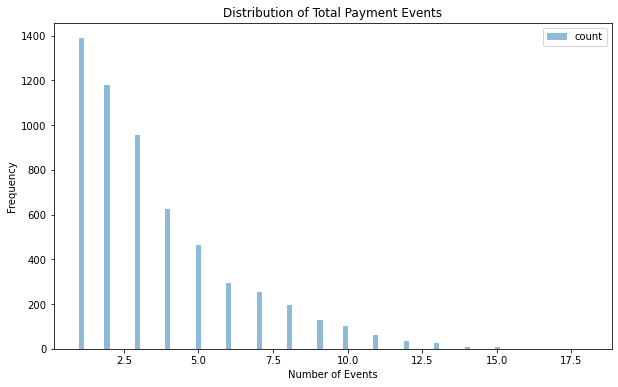

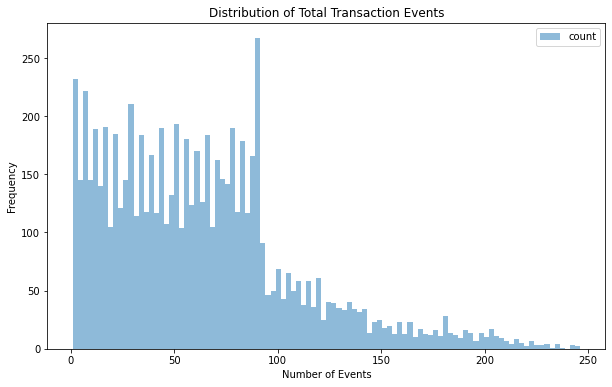

In [7]:
plot_event_distribution(payments_log, 'agent_id', 'Distribution of Total Payment Events', 'Number of Events')
plot_event_distribution(transactions_log, 'agent_id', 'Distribution of Total Transaction Events', 'Number of Events')

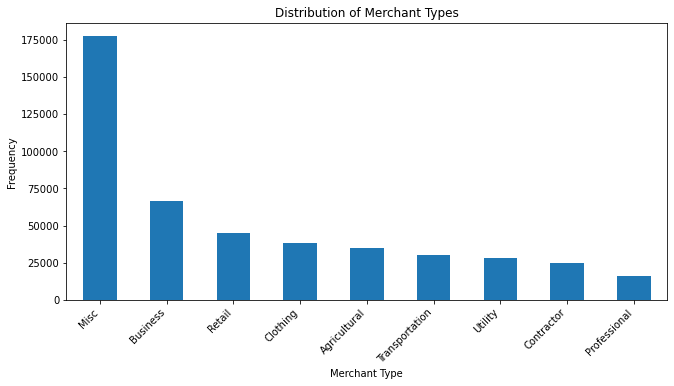

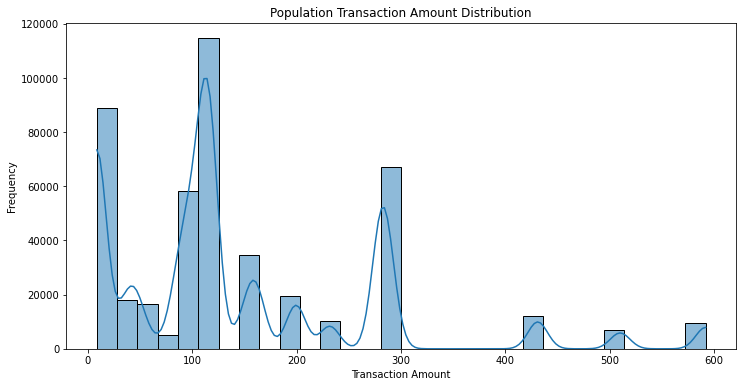

In [8]:
plot_merchant_type_distribution(transactions_log)
plot_transaction_amount_distribution(transactions_log)

Note in the following plots that different agents have time series that start at different points. This corresponds to credit cards opening at different times.

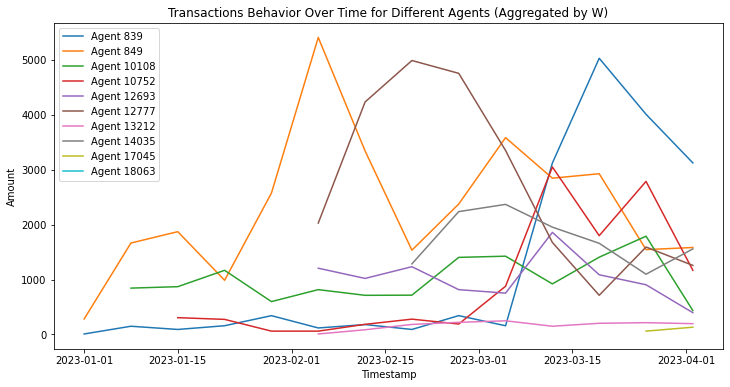

/Users/parkhiagarwal/Beyond_The_Hype/plotting.py:161: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  agent_log_resampled = agent_log['amount'].resample(period).sum()


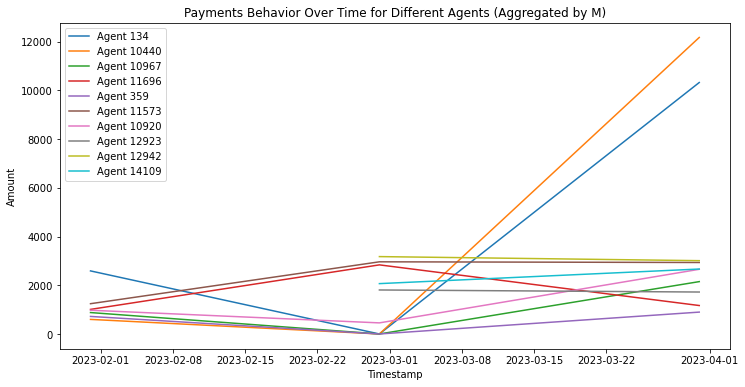

In [9]:
plot_behavior_over_time(transactions_log, sample_size=10, period='W', data_type='transactions')  # For transactions
plot_behavior_over_time(payments_log, sample_size=10, period='M', data_type='payments')  # For payments

In [10]:
labels = pd.read_csv('./Datasets/labels.csv')

In [11]:
labels.head()

,agent_id,charge_off_within_3_months,charge_off_within_6_months,charge_off_within_9_months,charge_off_within_12_months
0,0,0,0,0,0
1,3,0,0,0,0
2,6,0,0,0,0
3,7,0,0,0,0
4,8,0,0,0,0


In [12]:
labels.describe()

,agent_id,charge_off_within_3_months,charge_off_within_6_months,charge_off_within_9_months,charge_off_within_12_months
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,12658.073177,0.001632,0.009385,0.018362,0.027476
std,4744.594481,0.040370,0.096428,0.134267,0.163476
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11312.750000,0.000000,0.000000,0.000000,0.000000
50%,13616.500000,0.000000,0.000000,0.000000,0.000000
75%,15884.500000,0.000000,0.000000,0.000000,0.000000
max,18190.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Separate the majority and minority classes
train_data_majority = train_data[train_data.charge_off_within_3_months == 0]
train_data_minority = train_data[train_data.charge_off_within_3_months == 1]

# Upsample minority class
train_data_minority_upsampled = resample(train_data_minority, 
                                         replace=True,     # sample with replacement
                                         n_samples=len(train_data_majority),    # to match majority class
                                         random_state=42) # reproducible results

# Combine majority class with upsampled minority class
train_data_upsampled = pd.concat([train_data_majority, train_data_minority_upsampled])

# Display new class counts
print(train_data_upsampled.charge_off_within_3_months.value_counts())
